## **Ultralytics and other libraries install**

In [ ]:
#PIP install
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 1.0 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.

In [ ]:
## importing required libraries
import os
import shutil
import random

!pip install tqdm --upgrade
from tqdm.notebook import tqdm

## **Drive Mount**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **Augmentation**

Augmentation is done using the albumentation.ai which is an advanced library that helps the images to tranform in a given form. This dataset have been tranformed by horizontal flip, vertical flip, resizing and included with the original dataset for better training of the model

In [ ]:
import os
import json
import numpy as np
from PIL import Image
import albumentations as A

### **Bounding Box Class**

This class is used for working with the coordinations of the bounding boxes that are stored in the labels in YOLO format and turn them into pascal VOC format which is suitable for the albumentation

In [ ]:
class BoundingBox:
    def __init__(self, class_id, center_x, center_y, width, height):
        self.class_id = class_id
        self.center_x = center_x
        self.center_y = center_y
        self.width = width
        self.height = height

    def to_albumentations_bbox(self, image_width, image_height):
        # Convert to Pascal VOC format for Albumentations
        x_min = (self.center_x - self.width / 2) * image_width
        y_min = (self.center_y - self.height / 2) * image_height
        x_max = (self.center_x + self.width / 2) * image_width
        y_max = (self.center_y + self.height / 2) * image_height
        return [x_min, y_min, x_max, y_max]

    @staticmethod
    def from_albumentations_bbox(bbox, class_id, image_width, image_height):
        # Convert from Pascal VOC format back to YOLO format
        x_min, y_min, x_max, y_max = bbox
        center_x = (x_min + x_max) / 2 / image_width
        center_y = (y_min + y_max) / 2 / image_height
        width = (x_max - x_min) / image_width
        height = (y_max - y_min) / image_height
        return BoundingBox(class_id, center_x, center_y, width, height)

In [ ]:
def load_yolo_labels(label_path):
    boxes = []
    with open(label_path, 'r') as f:
        for line in f:
            class_id, center_x, center_y, width, height = map(float, line.strip().split())
            boxes.append(BoundingBox(class_id, center_x, center_y, width, height))
    return boxes

def save_yolo_labels(label_path, boxes):
    with open(label_path, 'w') as f:
        for box in boxes:
            f.write(f"{int(box.class_id)} {box.center_x} {box.center_y} {box.width} {box.height}\n")


### **Setting up paths for the augmentation -> input and output path directories**

In [ ]:
# Paths
image_dir = "/content/drive/MyDrive/dataset2/images/train"
label_dir = "/content/drive/MyDrive/dataset2/labels/train"
output_image_dir = "/content/drive/MyDrive/aug/images/train"
output_label_dir = "/content/drive/MyDrive/aug/labels/train"

os.makedirs(output_image_dir, exist_ok=True)
os.makedirs(output_label_dir, exist_ok=True)

### **Horizontal Flip**

In [ ]:
# Horizontal flip transformation
horizontal_flip_transform = A.Compose([
    A.HorizontalFlip(p=1.0)
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels']))


In [ ]:
# Process each image and its labels
for filename in os.listdir(image_dir):
    if (filename.endswith('.jpg') or filename.endswith('.png')) and filename != '80.png':
        # Load image
        image_path = os.path.join(image_dir, filename)
        print(f"Processing image: {image_path}")
        image = np.array(Image.open(image_path).convert("RGB"))
        image_height, image_width = image.shape[:2]

        # Load bounding boxes and labels
        label_path = os.path.join(label_dir, filename.replace('.jpg', '.txt').replace('.png', '.txt'))
        print(f"Loading labels from: {label_path}")
        boxes = load_yolo_labels(label_path)
        class_labels = [box.class_id for box in boxes]
        albumentations_bboxes = [box.to_albumentations_bbox(image_width, image_height) for box in boxes]

        # Apply transformation
        transform_pipeline_result = horizontal_flip_transform(
            image=image,
            bboxes=albumentations_bboxes,
            class_labels=class_labels
        )
        transformed_image = transform_pipeline_result["image"]
        transformed_bboxes = transform_pipeline_result["bboxes"]

        # Convert back to YOLO format
        transformed_boxes = [BoundingBox.from_albumentations_bbox(bbox, class_id, image_width, image_height)
                             for bbox, class_id in zip(transformed_bboxes, class_labels)]

        # Save transformed image
        transformed_image_filename = f"hf_{filename}"
        transformed_image_path = os.path.join(output_image_dir, transformed_image_filename)
        print(f"Saving transformed image to: {transformed_image_path}")
        Image.fromarray(transformed_image).save(transformed_image_path)

        # Save transformed bounding boxes and labels
        transformed_label_filename = f"hf_{filename.replace('.jpg', '.txt').replace('.png', '.txt')}"
        transformed_label_path = os.path.join(output_label_dir, transformed_label_filename)
        print(f"Saving transformed labels to: {transformed_label_path}")
        save_yolo_labels(transformed_label_path, transformed_boxes)

print("Processing complete!")

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/dataset2/images/train'

### **Hue Transform**

In [ ]:
# Hue transform pipeline
hue_transform = A.Compose([
    A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=1.0)
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels']))

In [ ]:
# Process each image and its labels
for filename in os.listdir(image_dir):
    if (filename.endswith('.jpg') or filename.endswith('.png')) and filename != '80.png':
        # Load image
        image_path = os.path.join(image_dir, filename)
        print(f"Processing image: {image_path}")
        image = np.array(Image.open(image_path).convert("RGB"))
        image_height, image_width = image.shape[:2]

        # Load bounding boxes and labels
        label_path = os.path.join(label_dir, filename.replace('.jpg', '.txt').replace('.png', '.txt'))
        print(f"Loading labels from: {label_path}")
        boxes = load_yolo_labels(label_path)
        class_labels = [box.class_id for box in boxes]
        albumentations_bboxes = [box.to_albumentations_bbox(image_width, image_height) for box in boxes]

        # Apply transformation
        transform_pipeline_result = hue_transform(
            image=image,
            bboxes=albumentations_bboxes,
            class_labels=class_labels
        )
        transformed_image = transform_pipeline_result["image"]
        transformed_bboxes = transform_pipeline_result["bboxes"]

        # Convert back to YOLO format
        transformed_boxes = [BoundingBox.from_albumentations_bbox(bbox, class_id, image_width, image_height)
                             for bbox, class_id in zip(transformed_bboxes, class_labels)]

        # Save transformed image
        transformed_image_filename = f"hue_{filename}"
        transformed_image_path = os.path.join(output_image_dir, transformed_image_filename)
        print(f"Saving transformed image to: {transformed_image_path}")
        Image.fromarray(transformed_image).save(transformed_image_path)

        # Save transformed bounding boxes and labels
        transformed_label_filename = f"hue_{filename.replace('.jpg', '.txt').replace('.png', '.txt')}"
        transformed_label_path = os.path.join(output_label_dir, transformed_label_filename)
        print(f"Saving transformed labels to: {transformed_label_path}")
        save_yolo_labels(transformed_label_path, transformed_boxes)

print("Processing complete!")

### **Vertical Flip**

In [ ]:
# Vertical flip transformation
vertical_flip_transform = A.Compose([
    A.VerticalFlip(p=1.0)
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels']))

In [ ]:
# Process each image and its labels
for filename in os.listdir(image_dir):
    if (filename.endswith('.jpg') or filename.endswith('.png')) and filename != '80.png':
        # Load image
        image_path = os.path.join(image_dir, filename)
        print(f"Processing image: {image_path}")
        image = np.array(Image.open(image_path).convert("RGB"))
        image_height, image_width = image.shape[:2]

        # Load bounding boxes and labels
        label_path = os.path.join(label_dir, filename.replace('.jpg', '.txt').replace('.png', '.txt'))
        print(f"Loading labels from: {label_path}")
        boxes = load_yolo_labels(label_path)
        class_labels = [box.class_id for box in boxes]
        albumentations_bboxes = [box.to_albumentations_bbox(image_width, image_height) for box in boxes]

        # Apply transformation
        transform_pipeline_result = vertical_flip_transform(
            image=image,
            bboxes=albumentations_bboxes,
            class_labels=class_labels
        )
        transformed_image = transform_pipeline_result["image"]
        transformed_bboxes = transform_pipeline_result["bboxes"]

        # Convert back to YOLO format
        transformed_boxes = [BoundingBox.from_albumentations_bbox(bbox, class_id, image_width, image_height)
                             for bbox, class_id in zip(transformed_bboxes, class_labels)]

        # Save transformed image
        transformed_image_filename = f"vf_{filename}"
        transformed_image_path = os.path.join(output_image_dir, transformed_image_filename)
        print(f"Saving transformed image to: {transformed_image_path}")
        Image.fromarray(transformed_image).save(transformed_image_path)

        # Save transformed bounding boxes and labels
        transformed_label_filename = f"vf_{filename.replace('.jpg', '.txt').replace('.png', '.txt')}"
        transformed_label_path = os.path.join(output_label_dir, transformed_label_filename)
        print(f"Saving transformed labels to: {transformed_label_path}")
        save_yolo_labels(transformed_label_path, transformed_boxes)

print("Processing complete!")

### **Resize Transform**

In [ ]:
# Resize transformation (change the size as needed)
resize_transform = A.Compose([
    A.Resize(416, 416, always_apply=True)
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels']))

In [ ]:
#Process each image and its labels
for filename in os.listdir(image_dir):
    if (filename.endswith('.jpg') or filename.endswith('.png')) and filename != '80.png':
        # Load image
        image_path = os.path.join(image_dir, filename)
        print(f"Processing image: {image_path}")
        image = np.array(Image.open(image_path).convert("RGB"))
        image_height, image_width = image.shape[:2]

        # Load bounding boxes and labels
        label_path = os.path.join(label_dir, filename.replace('.jpg', '.txt').replace('.png', '.txt'))
        print(f"Loading labels from: {label_path}")
        boxes = load_yolo_labels(label_path)
        class_labels = [box.class_id for box in boxes]
        albumentations_bboxes = [box.to_albumentations_bbox(image_width, image_height) for box in boxes]

        # Apply transformation
        transform_pipeline_result = resize_transform(
            image=image,
            bboxes=albumentations_bboxes,
            class_labels=class_labels
        )
        transformed_image = transform_pipeline_result["image"]
        transformed_bboxes = transform_pipeline_result["bboxes"]

        # Convert back to YOLO format
        transformed_boxes = [BoundingBox.from_albumentations_bbox(bbox, class_id, transformed_image.shape[1], transformed_image.shape[0])
                             for bbox, class_id in zip(transformed_bboxes, class_labels)]

        # Save transformed image
        transformed_image_filename = f"resize_{filename}"
        transformed_image_path = os.path.join(output_image_dir, transformed_image_filename)
        print(f"Saving transformed image to: {transformed_image_path}")
        Image.fromarray(transformed_image).save(transformed_image_path)

        # Save transformed bounding boxes and labels
        transformed_label_filename = f"resize_{filename.replace('.jpg', '.txt').replace('.png', '.txt')}"
        transformed_label_path = os.path.join(output_label_dir, transformed_label_filename)
        print(f"Saving transformed labels to: {transformed_label_path}")
        save_yolo_labels(transformed_label_path, transformed_boxes)

print("Processing complete!")

## **Training**

**YAML creation**

In [ ]:
data_yaml = """
train: /content/drive/MyDrive/aug/images/train
val: /content/drive/MyDrive/aug/images/val
test: /content/drive/MyDrive/aug/images/test

nc: 4
names: ['stumps', 'grease', 'bat', 'shoe']
"""

yaml_path = '/content/drive/MyDrive/aug/runout.yaml'

with open(yaml_path, 'w') as f:
    f.write(data_yaml)

**Train**

In [ ]:
!yolo task=detect mode=train model=yolov8s.pt data=/content/drive/MyDrive/aug/runout.yaml epochs=20 imgsz=640 batch=16 lr0=0.005
project=/content/drive/MyDrive/aug/training_result name=runout

Ultralytics YOLOv8.2.22 🚀 Python-3.10.12 torch-2.3.0+cu121 CPU (Intel Xeon 2.20GHz)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/content/drive/MyDrive/aug/runout.yaml, epochs=20, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=/content/drive/MyDrive/aug/training_result, name=runout6, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_cr

**Trial Test**

In [ ]:
!yolo task=detect mode=train model=/content/drive/MyDrive/aug/training_result/runout6/weights/best.pt data=/content/drive/MyDrive/aug/runout.yaml epochs=20 resume=True project=/content/drive/MyDrive/aug/training_result name=runout

Ultralytics YOLOv8.2.22 🚀 Python-3.10.12 torch-2.3.0+cu121 CPU (Intel Xeon 2.20GHz)
engine/trainer: task=detect, mode=train, model=/content/drive/MyDrive/aug/training_result/runout6/weights/best.pt, data=/content/drive/MyDrive/aug/runout.yaml, epochs=20, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=0, project=/content/drive/MyDrive/aug/training_result, name=runout6, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=/content/drive/MyDrive/aug/training_result/runout6/weights/best.pt, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, 

In [ ]:
!yolo task=detect mode=predict model=/content/drive/MyDrive/aug/training_result/runout6/weights/best.pt conf=0.55 source=/content/drive/MyDrive/aug/test/images.jpg

Ultralytics YOLOv8.2.75 🚀 Python-3.10.12 torch-2.3.1+cu121 CPU (Intel Xeon 2.20GHz)
Model summary (fused): 168 layers, 11,127,132 parameters, 0 gradients, 28.4 GFLOPs

image 1/1 /content/drive/MyDrive/aug/test/images.jpg: 480x640 1 stumps, 1 grease, 1 bat, 2 shoes, 534.7ms
Speed: 16.5ms preprocess, 534.7ms inference, 33.0ms postprocess per image at shape (1, 3, 480, 640)
Results saved to runs/detect/predict
💡 Learn more at https://docs.ultralytics.com/modes/predict


**Metrics**

In [ ]:
!yolo task=detect mode=val model=/content/drive/MyDrive/aug/training_result/runout6/weights/best.pt data=/content/drive/MyDrive/aug/runout.yaml


Ultralytics YOLOv8.2.26 🚀 Python-3.10.12 torch-2.3.0+cu121 CPU (Intel Xeon 2.20GHz)
Model summary (fused): 168 layers, 11127132 parameters, 0 gradients, 28.4 GFLOPs
100% 755k/755k [00:00<00:00, 27.7MB/s]
val: Scanning /content/drive/MyDrive/aug/labels/val.cache... 25 images, 0 backgrounds, 0 corrupt: 100% 25/25 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0% 0/2 [00:16<?, ?it/s]
Traceback (most recent call last):
  File "/usr/local/bin/yolo", line 8, in <module>
    sys.exit(entrypoint())
  File "/usr/local/lib/python3.10/dist-packages/ultralytics/cfg/__init__.py", line 583, in entrypoint
    getattr(model, mode)(**overrides)  # default args from model
  File "/usr/local/lib/python3.10/dist-packages/ultralytics/engine/model.py", line 528, in val
    validator(model=self.model)
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/_contextlib.py", line 115, in decorate_context
    return func(*args, **kwargs)
  File "

In [ ]:
from ultralytics import YOLO

# Load the model
model = YOLO('/content/drive/MyDrive/aug/training_result/runout6/weights/best.pt')

# Run prediction
results = model.predict(source='/content/drive/MyDrive/aug/test/images.jpg', conf=0.50, save=True, save_txt=True, project='/content/drive/MyDrive/aug/Predictions', name='results')

# Print results (optional)
for result in results:
    print(result)



image 1/1 /content/drive/MyDrive/aug/test/images.jpg: 480x640 1 stumps, 1 grease, 1 bat, 3 shoes, 477.8ms
Speed: 4.6ms preprocess, 477.8ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)
Results saved to /content/drive/MyDrive/aug/Predictions/results17
1 label saved to /content/drive/MyDrive/aug/Predictions/results17/labels
ultralytics.engine.results.Results object with attributes:

boxes: ultralytics.engine.results.Boxes object
keypoints: None
masks: None
names: {0: 'stumps', 1: 'grease', 2: 'bat', 3: 'shoe'}
obb: None
orig_img: array([[[ 76, 130, 117],
        [ 76, 130, 117],
        [ 76, 130, 117],
        ...,
        [ 77, 129, 119],
        [ 77, 129, 119],
        [ 77, 129, 119]],

       [[ 79, 133, 120],
        [ 79, 133, 120],
        [ 79, 133, 120],
        ...,
        [ 86, 138, 128],
        [ 86, 138, 128],
        [ 86, 138, 128]],

       [[ 83, 137, 124],
        [ 83, 137, 124],
        [ 83, 137, 124],
        ...,
        [ 87, 140, 130],
   

In [ ]:
#Predict and store the coordinates
!yolo task=detect mode=predict model=/content/drive/MyDrive/aug/training_result/runout6/weights/best.pt conf=0.50
source=/content/drive/MyDrive/aug/test/test.png
save_txt=True project=/content/drive/MyDrive/aug/Predictions name=results

SyntaxError: invalid syntax (<ipython-input-11-255ee985650c>, line 3)

In [ ]:
def load_one_yolo_labels(label_path):
    boxes = []
    with open(label_path, 'r') as f:
        for line in f:
            class_id, center_x, center_y, width, height = map(float, line.strip().split())
            boxes.append((int(class_id), center_x, center_y, width, height))  # Convert class_id to int
    return boxes

In [ ]:
# Function to parse YOLO label text file and return the predicted labels in a list
def parse_yolo_txt(image_path, label_path):
    objects = []

    # Load image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Unable to load image from {image_path}")
        return objects

    # Load labels
    boxes = load_one_yolo_labels(label_path)
    print(boxes)
    # Draw bounding boxes on the image and store the predicted labels in a list
    for box in boxes:
        class_id, center_x, center_y, width, height = box
        xmin = int((center_x - width / 2) * image.shape[1])
        ymin = int((center_y - height / 2) * image.shape[0])
        xmax = int((center_x + width / 2) * image.shape[1])
        ymax = int((center_y + height / 2) * image.shape[0])

        objects.append({
            'class_id': class_id,
            'xmin': xmin,
            'ymin': ymin,
            'xmax': xmax,
            'ymax': ymax
        })

        # Determine if the image is flipped
    flipped = None
    class_0 = next((obj for obj in objects if obj['class_id'] == 0), None)
    class_1 = next((obj for obj in objects if obj['class_id'] == 1), None)

    if class_0 and class_1:
        if class_0['xmin'] < class_1['xmin'] :
            flipped = False
        elif class_0['xmin'] > class_1['xmin'] :
            flipped = True





    return objects,flipped

In [ ]:
def findGreaseCenter(objects):

  for obj in objects:
    if obj['class_id'] == 1:  # Check for class ID 1 (crease)
      # Calculate center x of the bounding box
      center_x = (obj['xmin'] + obj['xmax']) / 2
      return center_x  # Return the first crease center_x

  return None  # No crease objects found

In [ ]:
# Checking the image side
# Batsman left stumps on right or batsman right stumps on left or if image is in vertical format
def locateStumpPosition(objects, crease_center_x):

    stumps_relative_to_crease = []
    for obj in objects:
        if obj['class_id'] == 0:  # Check if it's a stump (class ID 0)
            stump_center_x = (obj['xmin'] + obj['xmax']) // 2
            position = 0 if stump_center_x > crease_center_x else 1
            stumps_relative_to_crease.append({
                'class_id': obj['class_id'],
                'xmin': obj['xmin'],
                'ymin': obj['ymin'],
                'xmax': obj['xmax'],
                'ymax': obj['ymax'],
                'position': position
            })

    return stumps_relative_to_crease

In [ ]:
def createLine(obj, stump_position):

  if(stump_position['position']):
      x1 = obj['xmin']
      y1 = obj['ymin']
      x2 = obj['xmax']
      y2 = obj['ymax']

      # Check for division by zero (vertical line)
      if x1 == x2:
        return None, None  # Handle vertical line case

      slope = (y1 - y2) / (x2 - x1)  # Calculate slope
      y_intercept = y2 - slope * x1  # Calculate y-intercept

      return slope, y_intercept
  else:
      x1 = obj['xmin']
      y1 = obj['ymin']
      x2 = obj['xmax']
      y2 = obj['ymax']
      # Check for division by zero (vertical line)
      if x1 == x2:
        return None, None  # Handle vertical line case

      slope = (y1 - y2) / (x1 - x2)  # Calculate slope
      y_intercept = y1 - slope * x1  # Calculate y-intercept

      return slope, y_intercept

In [ ]:
def showPoints(image_path, obj, color=(0, 0, 255), thickness=5):

  # Read the image
  image = cv2.imread(image_path)

  if image is None:
    print(f"Error: Could not read image from '{image_path}'.")
    return

  # Extract object coordinates
  x1 = obj['xmin']
  y1 = obj['ymin']
  x2 = obj['xmax']
  y2 = obj['ymax']

  # Calculate center coordinates
  center_x = int((x1 + x2) / 2)
  center_y = int((y1 + y2) / 2)
   # Calculate center coordinates
  center_x = int((x1 + x2) / 2)
  center_y = int((y1 + y2) / 2)

  # Draw points for top-left, bottom-right corners, and center
  cv2.circle(image, (x1, y1), radius=thickness, color=color, thickness=-1)  # Filled circle for top-left
  cv2.circle(image, (x2, y1), radius=thickness, color=color, thickness=-1)  # Filled circle for top-right
  cv2.circle(image, (x1, y2), radius=thickness, color=color, thickness=-1)  # Filled circle for bottom-left
  cv2.circle(image, (x2, y2), radius=thickness, color=color, thickness=-1)  # Filled circle for bottom-right
  cv2.circle(image, (center_x, center_y), radius=thickness, color=color, thickness=-1)  # Filled circle for center (corrected)

  # Optionally display the image with points
  cv2_imshow(image)

In [ ]:
import cv2
from google.colab.patches import cv2_imshow

# Function to crop the grease region from the image
def cropGrease(objects, image):
    grease_object = None

    # Find the grease object
    for obj in objects:
        if obj['class_id'] == 1:  # Check for class ID 1 (grease)
            grease_object = obj
            break

    if grease_object is None:
        print("No grease object found in the image.")
        return None, None

    # Get bounding box coordinates
    xmin = grease_object['xmin']
    ymin = grease_object['ymin']
    xmax = grease_object['xmax']
    ymax = grease_object['ymax']
    print(f"Grease bounding box: xmin={xmin}, ymin={ymin}, xmax={xmax}, ymax={ymax}")

    # Ensure the coordinates are within the image dimensions
    height, width = image.shape[:2]
    xmin = max(0, min(xmin, width - 1))
    ymin = max(0, min(ymin, height - 1))
    xmax = max(0, min(xmax, width - 1))
    ymax = max(0, min(ymax, height - 1))

    # Crop the image using the bounding box coordinates
    cropped_image = image[ymin:ymax, xmin:xmax]

    return cropped_image, xmin




In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

# Function to detect lines and calculate mean slope and intercept
def calculateMeanSlopeIntercept(image):
    #Grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    cv2_imshow(gray)

    # Initialize Thresholds
    low_threshold = 50
    high_threshold = 150

    # Loop to adjust Canny thresholds if no lines are detected
    for canny_iteration in range(3):
        if canny_iteration == 1:
            low_threshold, high_threshold = 25, 50
        elif canny_iteration == 2:
            low_threshold, high_threshold = 75, 100

        # Apply Canny edge detection
        edges = cv2.Canny(gray, low_threshold, high_threshold, apertureSize=3)
        cv2_imshow(edges)

        threshold = 100  # Initial threshold for Hough Line Transform
        min_lines = 1
        lines = []

        while threshold > 0:
            # Detect lines using Hough Line Transform
            lines = cv2.HoughLinesP(edges, 1, np.pi/180, threshold, minLineLength=100, maxLineGap=10)

            # Check if at least one line is detected
            if lines is not None and len(lines) >= min_lines:
                break

            # Decrease threshold to detect fewer lines
            threshold -= 1

        # Break if lines are found
        if lines is not None and len(lines) >= min_lines:
            break

    if lines is None or len(lines) == 0:
        print("No lines detected")
        return None, None

    slopes = []
    intercepts = []

    # Calculate slopes and intercepts
    for line in lines:
        x1, y1, x2, y2 = line[0]
        if x2 != x1:  # Avoid division by zero
            slope = (y2 - y1) / (x2 - x1)
            intercept = y1 - slope * x1
            slopes.append(slope)
            intercepts.append(intercept)

            print(x1, y1, x2, y2)


    # Calculate mean slope and intercept
    mean_slope = np.mean(slopes)
    mean_intercept = np.mean(intercepts)

    return mean_slope, mean_intercept

In [ ]:
import cv2
from google.colab.patches import cv2_imshow

def drawInCropped(cropped_image, mean_slope, mean_intercept):
    # Calculate two points for the average line
    x1 = 0
    y1 = int(mean_intercept)
    x2 = int(cropped_image.shape[1])
    y2 = int(mean_slope * x2 + mean_intercept)

    # Draw the average line on the image
    cv2.line(cropped_image, (x1, y1), (x2, y2), (0, 0, 255), 2)  # Green color, line thickness 2

    # Calculate the region to crop based on the line coordinates
    min_x = min(x1, x2)
    max_x = max(x1, x2)
    min_y = min(y1, y2)
    max_y = max(y1, y2)

    # Add some padding if needed
    padding = 10
    min_x = max(min_x - padding, 0)
    max_x = min(max_x + padding, cropped_image.shape[1])
    min_y = max(min_y - padding, 0)
    max_y = min(max_y + padding, cropped_image.shape[0])

    # Crop the image
    cropped = cropped_image[min_y:max_y, min_x:max_x]

    # Save the cropped image
    cv2.imwrite('grease_image.jpg', cropped)

    # Display the cropped image
    cv2_imshow(cropped)
    print(mean_intercept)
    print(mean_slope)

# Example usage:
# Assuming cropped_grease_image is already defined, and mean_slope and mean_intercept are known
# cropped_grease_image = cv2.imread('path_to_image.jpg')
# drawInCropped(cropped_grease_image, mean_slope, mean_intercept)


In [ ]:
def lineOnFullimage(image, mean_slope, orginal_intercept):
    # Calculate two points for the average line
    x1 = 0
    y1 = int(orginal_intercept)
    x2 = int(image.shape[1])
    y2 = int(mean_slope * x2 + orginal_intercept)

    # Draw the average line on the image
    #cv2.line(image, (x1, y1), (x2, y2), (0, 255, 0), 2)  # Green color, line thickness 2

    # Calculate the region to crop based on the line coordinates
    min_x = min(x1, x2)
    max_x = max(x1, x2)
    min_y = min(y1, y2)
    max_y = max(y1, y2)

    # Add some padding if needed
    padding = 10
    min_x = max(min_x - padding, 0)
    max_x = min(max_x + padding, image.shape[1])
    min_y = max(min_y - padding, 0)
    max_y = min(max_y + padding, image.shape[0])

    # Crop the image
    orginal_with_line = image[min_y:max_y, min_x:max_x]

    # Save the cropped image
    cv2.imwrite('orginal_with_line.jpg', orginal_with_line)

    # Display the cropped image
    cv2_imshow(orginal_with_line)


In [ ]:
def createStumpToBatLine(stump, cbat):


  if not cbat:
    return None, None  # Handle no bat case

  bat_center_x = (bat_object['xmin'] + bat_object['xmax']) / 2

  stump_center_x = (stump['xmin'] + stump['xmax']) / 2

  slope = (stump['ymax'] - bat_object['ymax']) / (stump_center_x - bat_center_x)
  y_intercept = bat_object['ymax'] - slope * bat_center_x
  return slope, y_intercept

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
import numpy as np

def drawLine(image_path, slope, intercept, color=(0, 0, 255), thickness=2):


  # Read the image
  image = cv2.imread(image_path)

  if image is None:
    print(f"Error: Could not read image from '{image_path}'.")
    return

  # Get image height and width
  image_height, image_width, _ = image.shape
 # Calculate starting and ending points for the line
  # Ensure the line stays within image boundaries
  y_start = max(0, int(intercept))  # Clamp y-start to image top
  x_start = int((y_start - intercept) / slope)  # Calculate x-start based on y-start
  y_end = min(image_height - 1, int(slope * (image_width - 1) + intercept))  # Clamp y-end to image bottom
  x_end = int((y_end - intercept) / slope)  # Calculate x-end based on y-end

  # Draw the line on the image
  cv2.line(image, (x_start, y_start), (x_end, y_end), color, thickness)

  cv2_imshow(image)

In [ ]:
def findIntersectPoint(line1_params, line2_params):


  m1, b1 = line1_params
  m2, b2 = line2_params

  # Check for parallel lines
  if m1 == m2:
    return None  # Parallel lines

  # Calculate intersection point
  x_intersect = (b2 - b1) / (m1 - m2)
  y_intersect = m1 * x_intersect + b1

  return x_intersect, y_intersect

In [ ]:
import cv2
from google.colab.patches import cv2_imshow  # Only necessary if running in Google Colab

def showIntersectionPoint(image_path, coordinate_point, color=(255, 0, 0), radius=5, thickness=5):

    # Read the image
    image = cv2.imread(image_path)

    if image is None:
        print(f"Error: Could not read image from '{image_path}'.")
        return

    # Extract intersection coordinates
    x, y = coordinate_point

    # Draw a point at the intersection coordinates
    cv2.circle(image, (int(x), int(y)), radius=radius, color=color, thickness=thickness)  # Filled circle for intersection point

    # Optionally display the image with the intersection point
    cv2_imshow(image)

In [ ]:
import cv2
from google.colab.patches import cv2_imshow  # Only necessary if running in Google Colab

def showBothPoints(image_path, intersect_point,flipped, bat_point, intersect_color=(0, 0, 255), bat_color=(255, 0, 0), radius=5, thickness=5):

    # Read the image
    image = cv2.imread(image_path)

    if image is None:
        print(f"Error: Could not read image from '{image_path}'.")
        return

    # Extract intersection coordinates
    intx, inty = intersect_point

    # Extract bat closest coordinates
    batx = bat_point['xmax'] if flipped else bat_point['xmin']
    baty = bat_point['ymax']
     # Draw a point at the intersection coordinates
    cv2.circle(image, (int(intx), int(inty)), radius=radius, color=intersect_color, thickness=thickness)  # Intersection point
    cv2.circle(image, (int(batx), int(baty)), radius=radius, color=bat_color, thickness=thickness)  # bat point

    # Optionally display the image with the points
    cv2_imshow(image)

In [ ]:
import cv2
from google.colab.patches import cv2_imshow

def showBothPoints(image_path, intersect_point, bat_point, flipped, intersect_color=(255, 0, 0), bat_color=(0, 255, 0), radius=5, thickness=5):


    # Read the image
    image = cv2.imread(image_path)

    if image is None:
        print(f"Error: Could not read image from '{image_path}'.")
        return

    # Extract intersection coordinates
    intx, inty = intersect_point

    # Determine the bat point coordinates based on whether the image is flipped or not
    batx = bat_point['xmax'] if flipped else bat_point['xmin']
    baty = bat_point['ymax']

    # Draw a point at the intersection coordinates
    cv2.circle(image, (int(intx), int(inty)), radius=radius, color=intersect_color, thickness=thickness)  # Intersection point
    cv2.circle(image, (int(batx), int(baty)), radius=radius, color=bat_color, thickness=thickness)  # Bat point

    # Optionally display the image with the points
    cv2_imshow(image)


In [ ]:
def isOut(bat, intersection_point,stump_position):

  if(stump_position['position']):
    x_intersect, y_intersect = intersection_point
    bat_xmin = bat['xmin']
    bat_ymin = bat['ymax']


    return x_intersect < bat_xmin
  else:
    x_intersect, y_intersect = intersection_point
    bat_xmin = bat['xmax']
    bat_ymin_ymin = bat['ymin']


    return x_intersect > bat_xmin

In [ ]:
import cv2

# Function to load YOLO labels from a text file
def load_one_yolo_labels(label_path):
    boxes = []
    with open(label_path, 'r') as file:
        for line in file:
            parts = line.strip().split()
            if len(parts) == 5:
                class_id = int(parts[0])
                center_x = float(parts[1])
                center_y = float(parts[2])
                width = float(parts[3])
                height = float(parts[4])
                boxes.append((class_id, center_x, center_y, width, height))
    return boxes

# Function to parse YOLO label text file and return the predicted labels in a list
def parse_yolo_txt(image_path, label_path):
    objects = []

    # Load image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Unable to load image from {image_path}")
        return objects, None

    # Load labels
    boxes = load_one_yolo_labels(label_path)
    print("Loaded boxes:", boxes)

    # Draw bounding boxes on the image and store the predicted labels in a list
    for box in boxes:
        class_id, center_x, center_y, width, height = box
        xmin = int((center_x - width / 2) * image.shape[1])
        ymin = int((center_y - height / 2) * image.shape[0])
        xmax = int((center_x + width / 2) * image.shape[1])
        ymax = int((center_y + height / 2) * image.shape[0])

        objects.append({
            'class_id': class_id,
            'xmin': xmin,
            'ymin': ymin,
            'xmax': xmax,
            'ymax': ymax
        })

    # Determine if the image is flipped
    flipped = None
    class_0 = next((obj for obj in objects if obj['class_id'] == 0), None)
    class_1 = next((obj for obj in objects if obj['class_id'] == 1), None)

    if class_0 and class_1:
        if class_0['xmin'] < class_1['xmin']:
            flipped = False
        elif class_0['xmin'] > class_1['xmin']:
            flipped = True

    print("Objects before return:", objects)
    return objects, flipped

# Example usage
image_path = "/content/drive/MyDrive/aug/test/images.jpg"
label_path = "/content/drive/MyDrive/aug/Predictions/results17/labels/images.txt"


objects, flipped = parse_yolo_txt(image_path, label_path)

print("Type of objects:", type(objects))
print("Objects:", objects)  # Print the entire objects list to check its structure

if flipped is not None:
    if flipped:
        print("The image is flipped.")
    else:
        print("The image is not flipped.")
else:
    print("Not enough data to determine if the image is flipped.")


Loaded boxes: [(2, 0.275526, 0.49738, 0.180854, 0.15136), (0, 0.682689, 0.398595, 0.0622654, 0.300818), (3, 0.220799, 0.645735, 0.0621815, 0.0633163), (1, 0.350316, 0.540908, 0.0315633, 0.503518), (3, 0.752335, 0.521737, 0.107998, 0.086007), (3, 0.0743966, 0.649352, 0.0707567, 0.0551299)]
Objects before return: [{'class_id': 2, 'xmin': 47, 'ymin': 81, 'xmax': 94, 'ymax': 111}, {'class_id': 0, 'xmin': 168, 'ymin': 48, 'xmax': 184, 'ymax': 106}, {'class_id': 3, 'xmin': 49, 'ymin': 119, 'xmax': 65, 'ymax': 131}, {'class_id': 1, 'xmin': 86, 'ymin': 56, 'xmax': 94, 'ymax': 153}, {'class_id': 3, 'xmin': 180, 'ymin': 92, 'xmax': 208, 'ymax': 109}, {'class_id': 3, 'xmin': 10, 'ymin': 120, 'xmax': 28, 'ymax': 131}]
Type of objects: <class 'list'>
Objects: [{'class_id': 2, 'xmin': 47, 'ymin': 81, 'xmax': 94, 'ymax': 111}, {'class_id': 0, 'xmin': 168, 'ymin': 48, 'xmax': 184, 'ymax': 106}, {'class_id': 3, 'xmin': 49, 'ymin': 119, 'xmax': 65, 'ymax': 131}, {'class_id': 1, 'xmin': 86, 'ymin': 56, '

===== Object Data =====
Class ID: 2
Bounding Box: (47, 81) - (94, 111)
Class ID: 0
Bounding Box: (168, 48) - (184, 106)
Class ID: 3
Bounding Box: (49, 119) - (65, 131)
Class ID: 1
Bounding Box: (86, 56) - (94, 153)
Class ID: 3
Bounding Box: (180, 92) - (208, 109)
Class ID: 3
Bounding Box: (10, 120) - (28, 131)
Crease Centre X: 90.0
Stump Center X: 176
Stump Position: [{'class_id': 0, 'xmin': 168, 'ymin': 48, 'xmax': 184, 'ymax': 106, 'position': 0}]
Grease Object: {'class_id': 1, 'xmin': 86, 'ymin': 56, 'xmax': 94, 'ymax': 153}
Bat Object: {'class_id': 2, 'xmin': 47, 'ymin': 81, 'xmax': 94, 'ymax': 111}
Stump Object: {'class_id': 0, 'xmin': 168, 'ymin': 48, 'xmax': 184, 'ymax': 106}


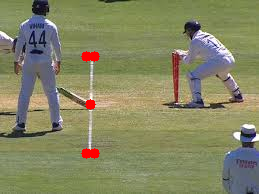

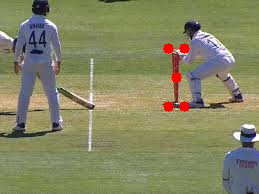

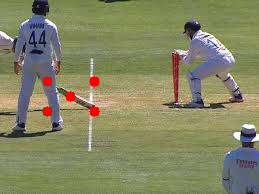

Grease bounding box: xmin=86, ymin=56, xmax=94, ymax=153


No lines detected
Mean Slope: None
Mean Intercept: None


TypeError: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'

In [ ]:
import cv2
from google.colab.patches import cv2_imshow

# Access individual object data:
print("===== Object Data =====")
for obj in objects:
    print(f"Class ID: {obj['class_id']}")
    print(f"Bounding Box: ({obj['xmin']}, {obj['ymin']}) - ({obj['xmax']}, {obj['ymax']})")
print("========================")

crease_centre_x = findGreaseCenter(objects)
print(f"Crease Centre X: {crease_centre_x}")
print("========================")

for obj in objects:
    if obj['class_id'] == 0:
        stump_center_x = (obj['xmin'] + obj['xmax']) // 2
        stumps_centre_x = stump_center_x
print(f"Stump Center X: {stump_center_x}")
print("========================")

stump_position = locateStumpPosition(objects, crease_centre_x)
print(f"Stump Position: {stump_position}")
print("========================")

#view = checkView(objects, image_path)



for obj in objects:
    if obj['class_id'] == 1:
        grease_object = obj
print(f"Grease Object: {grease_object}")
print("========================")


for obj in objects:
    if obj['class_id'] == 2:
        bat_object = obj
print(f"Bat Object: {bat_object}")
print("========================")

for obj in objects:
    if obj['class_id'] == 0:
        stump_object = obj
print(f"Stump Object: {stump_object}")
print("========================")

showPoints(image_path, grease_object)

showPoints(image_path, stump_object)

showPoints(image_path, bat_object)



# Path to save the cropped image
cropped_image_path = '/content/drive/MyDrive/aug/cropped/crop2.jpg'

# Load the image
image = cv2.imread(image_path)

# Crop the grease region from the image
cropped_image, xmin = cropGrease(objects, image)

# Save and display the cropped image
if cropped_image is not None:
    cv2.imwrite(cropped_image_path, cropped_image)
    cv2_imshow(cropped_image)
print("========================")

mean_slope, mean_intercept = calculateMeanSlopeIntercept(cropped_image)
print(f"Mean Slope: {mean_slope}")
print(f"Mean Intercept: {mean_intercept}")
print("========================")

drawInCropped(cropped_image, mean_slope, mean_intercept)

# Calculate the original intercept
orginal_intercept = mean_intercept - mean_slope * grease_object['xmin'] + grease_object['ymin']
print(f"Mean Slope: {mean_slope}")
print(f"Mean Intercept: {mean_intercept}")
print(f"Original Intercept: {orginal_intercept}")

print("========================")

lineOnFullimage(image, mean_slope, orginal_intercept)


# Grease line
grease_line_params = createLine(grease_object, stump_position[0])
print(f"Grease Line Parameters: {grease_line_params}")
print("========================")

# Stumps-shoe line
stump_bat_line_params = createStumpToBatLine(stump_object, bat_object)
print(f"Stump-Bat Line Parameters: {stump_bat_line_params}")
print("========================")

stump_bat_slope, stump_bat_intercept = stump_bat_line_params
drawLine(image_path, stump_bat_slope, stump_bat_intercept)

# Intersection
intersection_point = findIntersectPoint(grease_line_params, stump_bat_line_params)
x, y = intersection_point
print(f"Grease Line intersects Stump-Bat Line at: ({x:.2f}, {y:.2f})")
print("========================")

showIntersectionPoint(image_path, intersection_point)

showBothPoints(image_path, intersection_point, bat_object, flipped)

is_out = isOut(bat_object, intersection_point, stump_position[0])

# Critical output
print("\n" + "="*30)
if is_out:
    print("\n" + "*"*10 + " OUT " + "*"*10 + "\n")
else:
    print("\n" + "*"*10 + " NOT OUT " + "*"*10 + "\n")
print("="*30 + "\n")
